# XGB Regressor
XGBoost excels at complex, multivariate data with sharp changes, modeling non-linearities for high accuracy, while Prophet shines with clear seasonality/holidays, offering fast, interpretable, univariate forecasts, handling missing data easily, but potentially struggling with very complex patterns. 

In [40]:
# import libraries
import pandas as pd

import sys
sys.path.append('../0_DataPreparation')
from utils import plot_missing_heatmap

# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# read train and validation data frame from ../data/processed

df_train_clean = pd.read_csv("../data/processed/df_train_data_cleaned.csv")
df_validation_clean = pd.read_csv("../data/processed/df_validation_data_cleaned.csv")
df_test_clean = pd.read_csv("../data/processed/df_test_data_cleaned.csv")

# convert Datum column to datetime
df_train_clean['Datum'] = pd.to_datetime(df_train_clean['Datum'])
df_validation_clean['Datum'] = pd.to_datetime(df_validation_clean['Datum'])
df_test_clean['Datum'] = pd.to_datetime(df_test_clean['Datum'])


# add month to train
df_train_clean['month'] = df_train_clean['Datum'].dt.month
# add month to validation
df_validation_clean['month'] = df_validation_clean['Datum'].dt.month
# add month to test
df_test_clean['month']= df_test_clean['Datum'].dt.month

# print shape of the datasets
print(f"Train data shape: {df_train_clean.shape}")
print(f"Validation data shape: {df_validation_clean.shape}")
print(f"Test data shape: {df_test_clean.shape}")
#print(df_train_clean.head(2))
#print(df_test_clean.head(2))

# create a dataframe to keep track of experiment results. don't intialize if experiment_results already exists
if 'experiment_results' not in globals():
    experiment_results = pd.DataFrame(columns=['R2_Train', 'R2_Validation', 'MAPE_Validation', 'Selected_Columns', 'XGB_Params'])

# add another column to df_train_clean called last_day_of_year which is 1 if the date is the last day of the year, else 0
df_train_clean['last_day_of_year'] = df_train_clean['Datum'].dt.is_year_end.astype(int)
df_validation_clean['last_day_of_year'] = df_validation_clean['Datum'].dt.is_year_end.astype(int)
df_test_clean['last_day_of_year'] = df_test_clean['Datum'].dt.is_year_end.astype(int)

# add another column to df_train_clean called last_day_of_year_w5 which is 1 if Warengruppe_umsatz == 5.0 and last_day_of_year == 1, else 0
df_train_clean['last_day_of_year_w5'] = ((df_train_clean['Warengruppe_umsatz'] == 5.0) & (df_train_clean['last_day_of_year'] == 1)).astype(int)
df_validation_clean['last_day_of_year_w5'] = ((df_validation_clean['Warengruppe_umsatz'] == 5.0) & (df_validation_clean['last_day_of_year'] == 1)).astype(int)
df_test_clean['last_day_of_year_w5'] = ((df_test_clean['Warengruppe_umsatz'] == 5.0) & (df_test_clean['last_day_of_year'] == 1)).astype(int)

Train data shape: (7487, 18)
Validation data shape: (1841, 18)
Test data shape: (1830, 17)


In [41]:
# ignore some columns
drop_columns = ['Datum', 'umsatz_rolling7','temperature_2m_mean','sunshine_duration','is_saturday','is_sunday']

# drop columns if present
drop_columns = [col for col in drop_columns if col in df_train_clean.columns]

# drop columns from train and validation datasets
df_train_clean = df_train_clean.drop(columns=drop_columns)
df_validation_clean = df_validation_clean.drop(columns=drop_columns)



In [52]:
experiment_results.tail()

,R2_Train,R2_Validation,MAPE_Validation,Selected_Columns,XGB_Params
0,0.890986,0.812093,0.218111,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.05}"
1,0.920402,0.866861,0.214371,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.05}"
2,0.919051,0.865256,0.215767,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.05}"
3,0.920402,0.866861,0.214371,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.05}"
4,0.920402,0.866861,0.214371,"[Umsatz_umsatz, Warengruppe_umsatz, day_of_wee...","{'n_estimators': 90, 'learning_rate': 0.05}"


In [43]:
# Selected variables
# reducing variables to check if it improves model performance
# take only a subset of columns
selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'KielerWoche_kiwo', 'school_holiday','public_holiday','last_day_of_year']
df_train_clean = df_train_clean[selected_columns]
df_validation_clean = df_validation_clean[selected_columns]


In [44]:
categorical_cols = ['Warengruppe_umsatz', 'day_of_week','month','school_holiday','KielerWoche_kiwo','public_holiday','next_day_holiday','last_day_of_year','last_day_of_year_w5']  # adjust based on your data
categorical_cols = [col for col in categorical_cols if col in df_train_clean.columns]

df_train_clean_cat = pd.get_dummies(df_train_clean, columns=categorical_cols, drop_first=False)
df_validation_clean_cat = pd.get_dummies(df_validation_clean, columns=categorical_cols, drop_first=False)
# align the validation set to have the same columns as the training set
df_validation_clean_cat = df_validation_clean_cat.reindex(columns=df_train_clean_cat.columns, fill_value=0)

# XGBoost

R2 on train: 0.920
R2 on validation: 0.867
MAPE on validation: 0.214
Features
Temperatur_weather: 0.007
Warengruppe_umsatz_1.0: 0.006
Warengruppe_umsatz_2.0: 0.641
Warengruppe_umsatz_3.0: 0.021
Warengruppe_umsatz_4.0: 0.002
Warengruppe_umsatz_5.0: 0.192
Warengruppe_umsatz_6.0: 0.001
day_of_week_0: 0.001
day_of_week_1: 0.000
day_of_week_2: 0.001
day_of_week_3: 0.000
day_of_week_4: 0.001
day_of_week_5: 0.006
day_of_week_6: 0.013
month_1: 0.001
month_2: 0.004
month_3: 0.001
month_4: 0.003
month_5: 0.005
month_6: 0.000
month_7: 0.006
month_8: 0.008
month_9: 0.002
month_10: 0.002
month_11: 0.002
month_12: 0.002
school_holiday_0.0: 0.011
school_holiday_1.0: 0.000
KielerWoche_kiwo_0.0: 0.003
KielerWoche_kiwo_1.0: 0.000
public_holiday_0.0: 0.005
public_holiday_1.0: 0.000
last_day_of_year_0: 0.052
last_day_of_year_1: 0.000


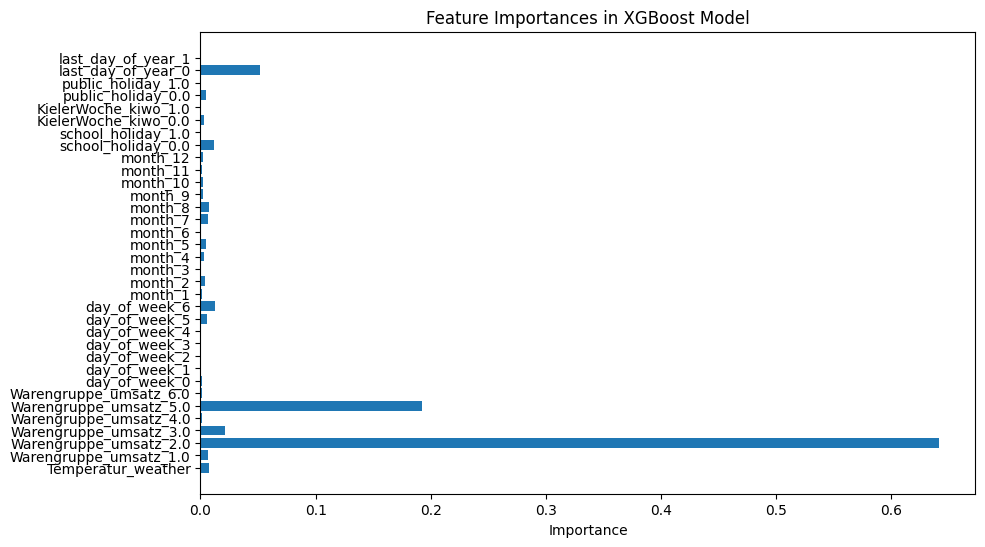

In [45]:
# xgbost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# prepare features and target (same as before)
target = 'Umsatz_umsatz'
X_train = df_train_clean_cat.drop(columns=[target])
y_train = df_train_clean_cat[target]
X_validation = df_validation_clean_cat.drop(columns=[target])
y_validation = df_validation_clean_cat[target]

# set hyperparameters
N_ESTIMATORS=90
LEARNING_RATE=0.05


# fit XGBoost
xgb_model = XGBRegressor(n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, random_state=42)
xgb_model.fit(X_train, y_train)

# predict and evaluate
y_train_pred = xgb_model.predict(X_train)
y_validation_pred = xgb_model.predict(X_validation)

r2_train = r2_score(y_train, y_train_pred)
r2_validation = r2_score(y_validation, y_validation_pred)
mape_validation = mean_absolute_percentage_error(y_validation, y_validation_pred)

print(f"R2 on train: {r2_train:.3f}")
print(f"R2 on validation: {r2_validation:.3f}")
print(f"MAPE on validation: {mape_validation:.3f}")

# for every run push the R2 scores and MAPE with the selected columns list to dataframe to keep record of experiments also add model hyperparameters if needed
experiment_results = pd.concat([experiment_results, pd.DataFrame({
    'R2_Train': [r2_train],
    'R2_Validation': [r2_validation],
    'MAPE_Validation': [mape_validation],
    'Selected_Columns': [selected_columns],
    'XGB_Params': [{'n_estimators': N_ESTIMATORS, 'learning_rate': LEARNING_RATE}]
})], ignore_index=True)


print("Features")
feature_importances = xgb_model.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance:.3f}")

# optional: plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importances in XGBoost Model')
plt.show()


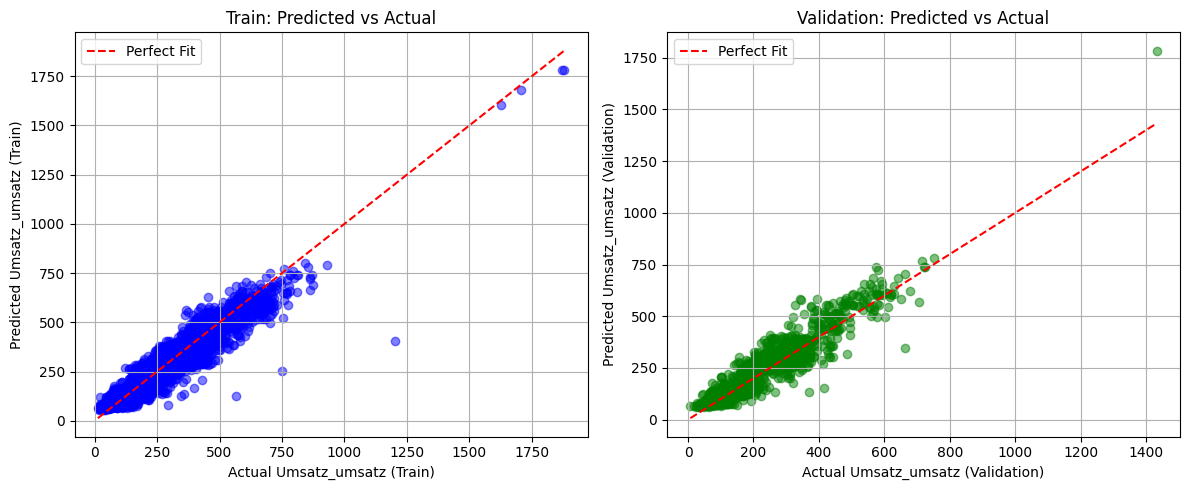

Number of outliers in validation (beyond 3 SD): 27 out of 1841


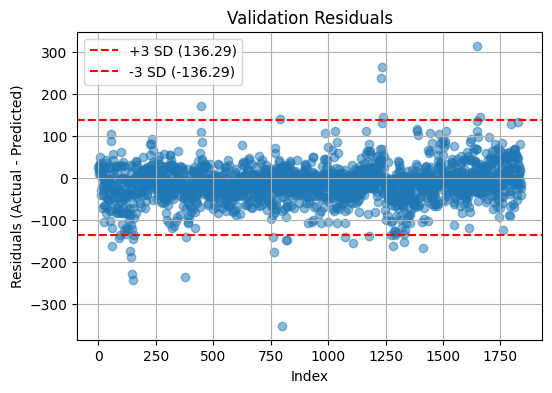

In [46]:
# plot predicted vs actual for train and validation
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# train plot
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Umsatz_umsatz (Train)')
axes[0].set_ylabel('Predicted Umsatz_umsatz (Train)')
axes[0].set_title('Train: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# validation plot
axes[1].scatter(y_validation, y_validation_pred, alpha=0.5, color='green')
axes[1].plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Umsatz_umsatz (Validation)')
axes[1].set_ylabel('Predicted Umsatz_umsatz (Validation)')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


# calculate residuals for validation
residuals_validation = y_validation - y_validation_pred

# define outliers as residuals beyond 3 standard deviations
threshold = 3 * residuals_validation.std()
outliers_count = (residuals_validation.abs() > threshold).sum()

print(f"Number of outliers in validation (beyond 3 SD): {outliers_count} out of {len(residuals_validation)}")

# optional: plot residuals to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(range(len(residuals_validation)), residuals_validation, alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'+3 SD ({threshold:.2f})')
plt.axhline(y=-threshold, color='r', linestyle='--', label=f'-3 SD ({-threshold:.2f})')
plt.xlabel('Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Validation Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
"""
from sklearn.model_selection import GridSearchCV


# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.1]
}

# Initialize model with fixed params
xgb_model = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Best params and score
print("Best params:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)

# Use best model
best_model = grid_search.best_estimator_

# Evaluate best model on validation set
y_validation_pred_best = best_model.predict(X_validation)
r2_validation_best = r2_score(y_validation, y_validation_pred_best)
mape_validation_best = mean_absolute_percentage_error(y_validation, y_validation_pred_best)

print(f"Best model - R² on validation: {r2_validation_best:.3f}")
print(f"Best model - MAPE on validation: {mape_validation_best:.3f}")
"""


'\nfrom sklearn.model_selection import GridSearchCV\n\n\n# Define parameter grid\nparam_grid = {\n    \'max_depth\': [3, 5, 7],\n    \'min_child_weight\': [1, 5],\n    \'gamma\': [0, 0.1],\n    \'subsample\': [0.8, 1.0],\n    \'colsample_bytree\': [0.8, 1.0],\n    \'reg_alpha\': [0, 0.01],\n    \'reg_lambda\': [1, 1.1]\n}\n\n# Initialize model with fixed params\nxgb_model = XGBRegressor(n_estimators=90, learning_rate=0.05, random_state=42)\n\n# Perform grid search\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring=\'r2\', verbose=1)\ngrid_search.fit(X_train, y_train)\n\n# Best params and score\nprint("Best params:", grid_search.best_params_)\nprint("Best R²:", grid_search.best_score_)\n\n# Use best model\nbest_model = grid_search.best_estimator_\n\n# Evaluate best model on validation set\ny_validation_pred_best = best_model.predict(X_validation)\nr2_validation_best = r2_score(y_validation, y_validation_pred_best)\nmape_validation_best = mean_absolute_

# XGBoost combined

In [48]:

# merge df_train_clean and df_validation_clean and create df_combined
df_combined = pd.concat([df_train_clean, df_validation_clean], ignore_index=True)
df_combined.head()

,Umsatz_umsatz,Warengruppe_umsatz,day_of_week,Temperatur_weather,month,KielerWoche_kiwo,school_holiday,public_holiday,last_day_of_year
0,148.828353,1.0,0,17.8375,7,0.0,1.0,0.0,0
1,535.856285,2.0,0,17.8375,7,0.0,1.0,0.0,0
2,201.198426,3.0,0,17.8375,7,0.0,1.0,0.0,0
3,65.890169,4.0,0,17.8375,7,0.0,1.0,0.0,0
4,317.475875,5.0,0,17.8375,7,0.0,1.0,0.0,0


In [49]:
# reducing variables
#selected_columns = ['Umsatz_umsatz', 'Warengruppe_umsatz', 'day_of_week', 'Temperatur_weather', 'month', 'school_holiday', 'KielerWoche_kiwo']
# using selected column that we used above
df_combined = df_combined[selected_columns]

In [50]:
# ...existing code...

categorical_cols = ['Warengruppe_umsatz', 'day_of_week','month','school_holiday','KielerWoche_kiwo','public_holiday','next_day_holiday'] # adjust based on your data

categorical_cols = [col for col in categorical_cols if col in df_combined.columns]
df_combined = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=False)

# do categorical encoding for test set as well
df_test_clean = pd.get_dummies(df_test_clean, columns=categorical_cols, drop_first=False)

#save id column before reindexing
df_test_id = df_test_clean['id']


df_test_clean = df_test_clean.reindex(columns=df_combined.columns, fill_value=0)
# prepare combined features and target
X_combined = df_combined.drop(columns=[target])
y_combined = df_combined[target]

# fit XGBoost on combined data
xgb_model_combined = XGBRegressor(n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, random_state=42)
xgb_model_combined.fit(X_combined, y_combined)

#print feature importances for combined model
print("Features for combined model")
feature_importances_combined = xgb_model_combined.feature_importances_
for feature, importance in zip(X_combined.columns, feature_importances_combined):
    print(f"{feature}: {importance:.3f}")


# only predict on test set
y_test = df_test_clean[target]



X_test = df_test_clean.drop(columns=[target])
y_test_pred = xgb_model_combined.predict(X_test)

# head y_test_pred
print("Test set predictions (first 10):")

print(df_test_clean.head())


Features for combined model
Temperatur_weather: 0.007
last_day_of_year: 0.046
Warengruppe_umsatz_1.0: 0.008
Warengruppe_umsatz_2.0: 0.625
Warengruppe_umsatz_3.0: 0.026
Warengruppe_umsatz_4.0: 0.001
Warengruppe_umsatz_5.0: 0.210
Warengruppe_umsatz_6.0: 0.001
day_of_week_0: 0.001
day_of_week_1: 0.000
day_of_week_2: 0.001
day_of_week_3: 0.000
day_of_week_4: 0.000
day_of_week_5: 0.006
day_of_week_6: 0.012
month_1: 0.001
month_2: 0.003
month_3: 0.001
month_4: 0.003
month_5: 0.003
month_6: 0.001
month_7: 0.008
month_8: 0.007
month_9: 0.001
month_10: 0.003
month_11: 0.002
month_12: 0.002
school_holiday_0.0: 0.010
school_holiday_1.0: 0.000
KielerWoche_kiwo_0.0: 0.004
KielerWoche_kiwo_1.0: 0.000
public_holiday_0.0: 0.005
public_holiday_1.0: 0.000
Test set predictions (first 10):
   Umsatz_umsatz  Temperatur_weather  last_day_of_year  \
0              0             23.7625                 0   
1              0             23.7625                 0   
2              0             23.7625         

In [51]:
# combine df_test_id with y_test_pred into a new dataframe df_xboost_test_predictions
df_xboost_test_predictions = pd.DataFrame({
    'id': df_test_id,
    'umsatz': y_test_pred
})
print(df_xboost_test_predictions.head(10))

# save df_xboost_test_predictions to ../data/processed/xgboost_test_predictions.csv
df_xboost_test_predictions.to_csv("../data/processed/xgboost_test_predictions.csv", index=False)

        id      umsatz
0  1808011  142.868149
1  1808012  524.292847
2  1808013  278.758484
3  1808014   84.987045
4  1808015  307.176819
5  1808021  147.097641
6  1808022  568.213806
7  1808023  280.436981
8  1808024   85.872925
9  1808025  308.300018
